In [1]:
import sys
sys.path.append("C:/Users/jnevin/Documents/GitHub/networkdiffusionanalyser")

from netdiffanalyse.parameter_sweeper import CombinationBuilder, ParameterSweeper, MultiNetworkDiffusion
from netdiffanalyse.diffusionmodel.ndlib_diffusionmodel import CustomDiffusionModel
%matplotlib inline

no display found. Using non-interactive Agg backend
no display found. Using non-interactive Agg backend
no display found. Using non-interactive Agg backend


In [2]:
import pandas as pd
import numpy as np
import networkx as nx

test_df = pd.read_csv('dedup_test_df.csv')
test_df.index = test_df.rec_id
test_df = test_df.drop(columns = ['rec_id'])

test_matches = np.load('dedup_test_matches.npy', allow_pickle = True)
test_matches = pd.MultiIndex.from_tuples(test_matches)

test_graph = nx.read_gml('dedup_test_graph.gml')

In [3]:
test_dict = test_df.to_dict()
full_graph_attr = test_graph.copy()

for attribute in test_dict:
    nx.set_node_attributes(full_graph_attr, test_dict[attribute], attribute)

In [4]:
# different blocking setups
test_block_0 = {'Block': [['given_name', 'given_name']]}
test_block_1 = {'Block': [['surname', 'surname']]}
all_test_blocks = [test_block_0, test_block_1]

# different comparison setups
test_compare_0 = {'Exact':  [['given_name', 'given_name'], ['date_of_birth', 'date_of_birth'],
                          ['suburb', 'suburb'], ['state', 'state']],
                'String': [['surname', 'surname', 'jarowinkler', 0.85], ['address_1', 'address_1', 'levenshtein', 0.85]]}

test_compare_1 = {'Exact':  [['surname', 'surname'], ['suburb', 'suburb'], ['state', 'state']],
                'String': [['given_name', 'given_name', 'jarowinkler', 0.85], ['address_1', 'address_1', 'levenshtein', 0.85]]}

all_test_compares = [test_compare_0, test_compare_1]

# different classifier setups
classifier_name_0 = 'NaiveBayesClassifier'
classifier_name_1 = 'LogisticRegressionClassifier'
all_classifier_names = [classifier_name_0, classifier_name_1]

# clustering algorithms
clustering_algs = ['walktrap_integration']

In [5]:
combination_builder = CombinationBuilder(all_test_blocks, all_test_compares, all_classifier_names, clustering_algs)
integration_setups = combination_builder.get_all_combinations()

graphs = [full_graph_attr]
training_matches = test_matches

parameter_sweeper = ParameterSweeper(integration_setups, graphs, training_matches)
different_integrated_networks = parameter_sweeper.get_integrated_networks()

In [6]:
# all the other features of the pipeline 
statuses = ['Susceptible', 'Infected', 'Removed']
compartments = {'NodeStochastic': {'c1': [0.02, 'Infected'], 'c2': [0.01]}}
transition_rules = [["Susceptible", "Infected", "c1"], ["Infected", "Removed", "c2"]]
model_parameters = [['fraction_infected', 0.1]]
simulation_parameters = [5, 600, None, 5]
model_name = 'sir'

custom_diffusion_model = CustomDiffusionModel(statuses, compartments,
                                             transition_rules, model_parameters)
# custom_diffusion_model = CustomDiffusionModel.SIR(0.02, 0.01, 0.1)

In [7]:
multi_network_diffusion = MultiNetworkDiffusion(different_integrated_networks, custom_diffusion_model)
graph_assc_results_analysers = multi_network_diffusion.run_diffusion_model(simulation_parameters)

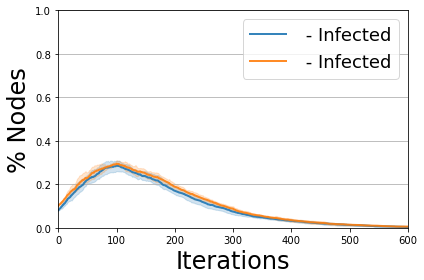

In [8]:
graph_assc_results_analysers.plot_trend_comparison([0,3])

In [9]:
graph_assc_results_analysers.get_average_stat_comparison([0,1,2])

,Susceptible_peak,Infected_peak,Removed_peak,Susceptible_final,Infected_final,Removed_final
0,0.900302,0.359517,0.805438,0.190030,0.004532,0.805438
1,0.900000,0.314595,0.728649,0.266486,0.004865,0.728649
2,0.900000,0.327536,0.759420,0.236812,0.003768,0.759420


In [ ]:
graph_assc_results_analysers.get_graph_prop_comparison()